In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
import time
from sklearn.linear_model import LinearRegression
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

N = 600

# Uneven (intended) timestamps from 0 to 600
t = np.arange(0, N, 1).reshape(-1,1)
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
t = np.array(np.round(t, 2))

# Creating 3 variables from 0 to 600 (value between 0 and 5)
x1 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x2 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x3 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)

# Creating 1 variable from 0 to 600 (value between 0 and 2)
n = np.round((np.random.random(N) * 2).reshape(-1,1), 2)

# Complex mathematic function using the variables that we'll want to predict
y = np.array([((np.log(np.abs(2 + x1[t])) - x2[t-1]**2) + 0.02*x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])
y = np.round(y+n, 2)

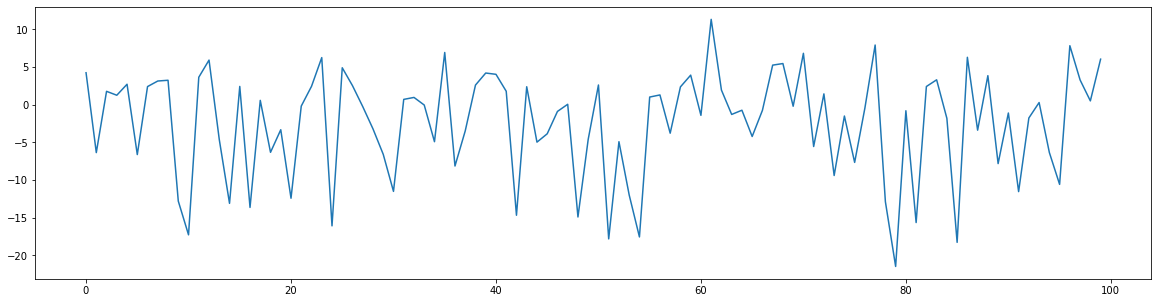

In [2]:
plt.plot(y[0:100])


In [3]:
#Creating a dataset (timestamp, delta t, x1, x2, x3, y)

dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

,t,∆t,x1,x2,x3,y
0,-0.07,0.00,1.79,3.06,1.32,4.25
1,1.07,1.14,2.77,0.42,3.86,-6.36
2,2.00,0.93,0.30,1.14,0.29,1.78


In [4]:
class WindowSlider(object):
    
    def __init__(self, window_size = 5):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size=5, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

In [5]:
trainset = dataset[dataset["t"] < 500]
testset = dataset[dataset["t"] >= 500]

w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:],
                                                previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:],
                                                previous_y=True)

# train_windows.head(3)
test_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,0.89,2.05,2.99,3.86,3.72,2.13,4.05,4.93,3.40,...,2.12,2.47,2.18,0.26,3.65,4.93,0.66,0.93,4.93,0.16
1,0.0,1.16,2.10,2.97,4.04,2.13,4.05,4.93,3.40,0.55,...,2.47,2.18,1.73,3.65,4.93,0.66,0.93,2.09,5.18,-0.60
2,0.0,0.94,1.81,2.88,4.02,4.05,4.93,3.40,0.55,3.51,...,2.18,1.73,2.11,4.93,0.66,0.93,2.09,2.49,5.02,-1.68


In [6]:
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods=1)

bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')

RMSE = 9.78
Time to train = 0 seconds


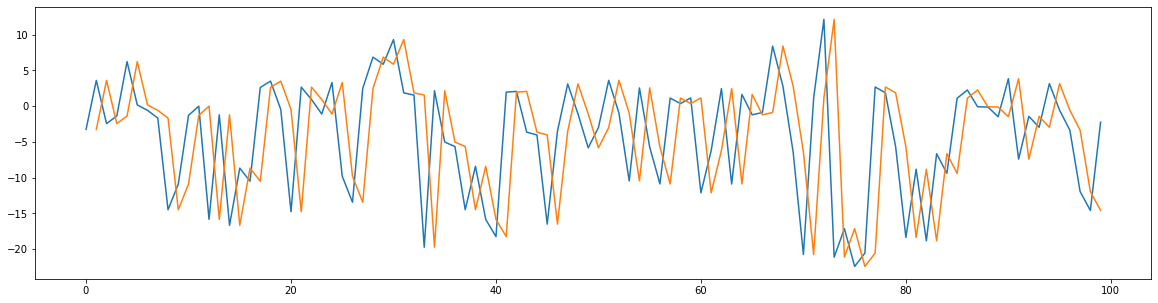

In [7]:
plt.plot(range(0,100), bl_y[0:100])
plt.plot(range(0,100), bl_y_pred[0:100])

In [8]:
# ______________ MULTIPLE LINEAR REGRESSION ______________
lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1]) # fit(column-1, last column)

t0 = time.time()
lr_y = testset['y'].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))## RMSE = 8.61 
## Time to train = 0.00 seconds

RMSE = 7.82
Time to train = 0.00 seconds


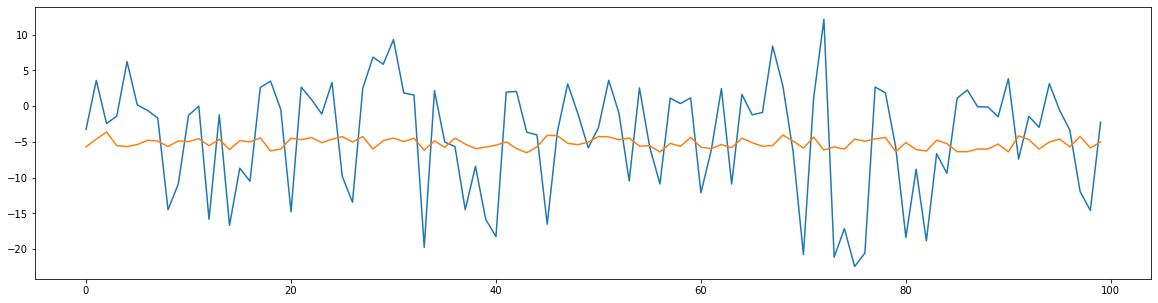

In [9]:
plt.plot(lr_y)
plt.plot(lr_y_pred)

In [10]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y = test_windows['Y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))## RMSE = 3.84
## Time to train = 0.00 seconds

RMSE = 2.65
Time to train = 0.00 seconds


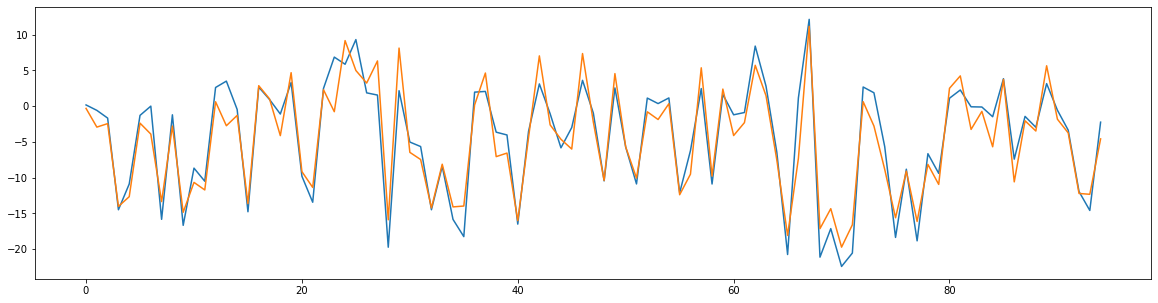

In [11]:
plt.plot(lr_y)
plt.plot(lr_y_pred)

In [12]:
#######################
# CREATION OF THE MODEL
#######################

import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# It is possible to create custom operations to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
# function_set = ['add', 'sub', 'mul', 'div', 'sin', 'log']#, xexp]
function_set = ['add', 'sub', 'mul', 'div']

if 'model' in locals(): del model
model = SymbolicRegressor(population_size = 3000, tournament_size=5,
                          generations = 25, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)

###########################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values y
###########################################################

# Train
t0 = time.time()
model.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict
sr_y_fit = model.predict(train_windows.values[:,:-1]).reshape(-1,1)
sr_y_pred = model.predict(test_windows.values[:,:-1]).reshape(-1,1)

# Calculating Errors
sr_residuals = sr_y_pred - testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse = np.sqrt(np.sum(np.power(sr_residuals,2)) / len(sr_residuals))
print('RMSE = %f' % sr_rmse)
print('Time to train %.2f' % (tF - t0))
print(model._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.38      1.12261e+06        7          6.20234              N/A     34.29s
   1     9.13          43.7397        5          6.04718              N/A     23.47s
   2     7.19           12.955       17          5.12838              N/A     23.48s
   3     6.10          1375.62        7          4.01688              N/A     22.70s
   4     6.41          13.6995        7          4.01688              N/A     22.00s
   5     7.14          18.4571        7          3.96016              N/A     21.50s
   6     7.65          18.8799       11          3.39257              N/A     20.99s
   7     8.12          21.8932        9          2.61576              N/A     22.03s
   8     8.75          153.386        9          2.61576              N/A  

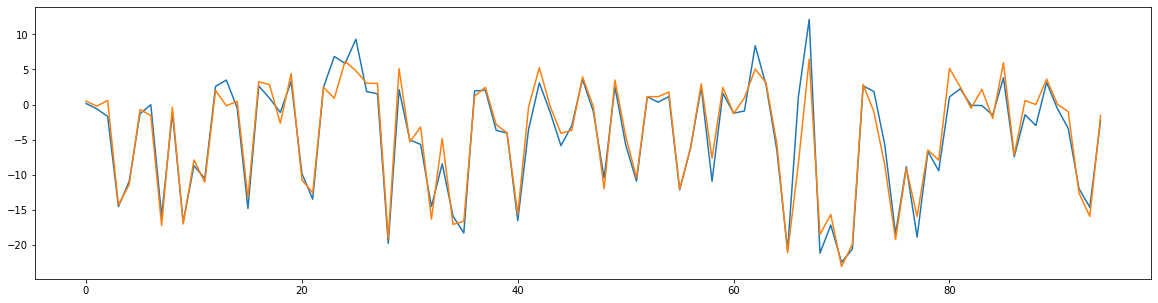

In [20]:
plt.plot(pd.DataFrame(lr_y))
plt.plot(sr_y_pred)

In [18]:
#################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
#################################################

if 'model_inc' in locals(): del model_inc
model_inc = SymbolicRegressor(population_size = 3000, tournament_size=5,
                          generations = 25, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)
# Train
t0 = time.time()
model_inc.fit(train_windows_y_inc.values[:,:-1], train_windows_y_inc.values[:,-1])
tF = time.time()

# Predict
sr_y_fit_inc = model_inc.predict(train_windows_y_inc.values[:,:-1]).reshape(-1,1)
sr_y_pred_inc = model_inc.predict(test_windows_y_inc.values[:,:-1]).reshape(-1,1)

# Calculating Errors
sr_residuals_inc = sr_y_pred_inc - testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse_inc = np.sqrt(np.sum(np.power(sr_residuals_inc,2)) / len(sr_residuals_inc))
print('RMSE = %f' % sr_rmse_inc)
print('Time to train %.2f' % (tF - t0))
print(model_inc._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.08      5.51686e+06        3          5.74278              N/A     17.52s
   1     8.83          78.0741        5          5.40639              N/A     22.52s
   2     8.39          109.488        5          5.40639              N/A     24.51s
   3     5.81          1091.37        7          4.32601              N/A     23.22s
   4     5.44          7399.32        7          4.30412              N/A     29.10s
   5     6.22          129.537       11          3.96016              N/A     21.11s
   6     6.31          1238.25        7          3.96016              N/A     19.67s
   7     6.13          133.994        7          2.84481              N/A     19.81s
   8     6.84          33.6983        7          2.84481              N/A  

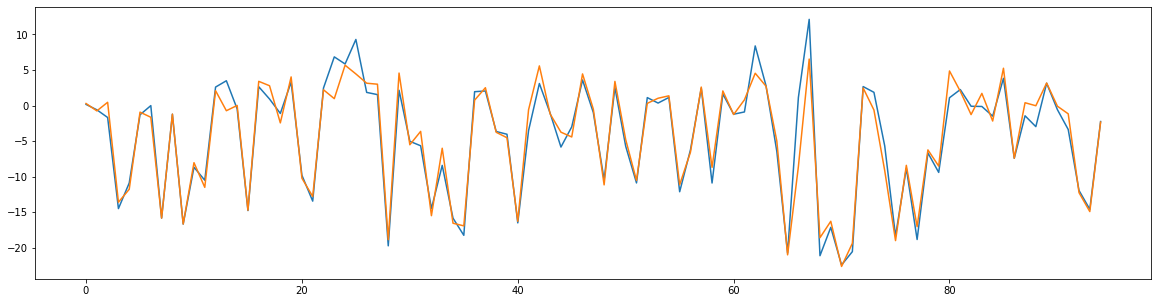

In [19]:
plt.plot(lr_y)
plt.plot(sr_y_pred_inc)